<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Define-Process" data-toc-modified-id="Define-Process-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Process</a></span></li><li><span><a href="#System-Verification" data-toc-modified-id="System-Verification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>System Verification</a></span></li><li><span><a href="#Integrate-Statistics" data-toc-modified-id="Integrate-Statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Integrate Statistics</a></span></li><li><span><a href="#System-Validation" data-toc-modified-id="System-Validation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>System Validation</a></span></li><li><span><a href="#Simulation-Study" data-toc-modified-id="Simulation-Study-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Simulation Study</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Load Libraries

In [74]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np

import simpy
import simpy.events as evt

# Prepare Data

In [107]:
dt=pd.read_csv('LondonBirhimgam.csv')
blocks =10

In [108]:
dt.head()

,Line,Direction,From,To,Distance,Running Time,Peak Running Time,Off-Peak Running Time,Speed
0,HS2,L2B,London Euston,London Old Oak Common,23.387097,5,5,5,4.677419
1,HS2,L2B,London Old Oak Common,Birmingham Interchange,145.000000,31,31,31,4.677419
2,HS2,L2B,Birmingham Interchange,Birmingham Curzon Street,42.096774,9,9,9,4.677419


Convert distances to meters

In [109]:
dt['Distance']=dt['Distance'].apply(lambda x: int(x*1000))

Convert running times into seconds

In [110]:
dt['Running Time']=dt['Running Time'].apply(lambda x: int(x*60))
dt['Peak Running Time']=dt['Peak Running Time'].apply(lambda x: int(x*60))
dt['Off-Peak Running Time']=dt['Off-Peak Running Time'].apply(lambda x: int(x*60))

In [111]:
dt.head()

,Line,Direction,From,To,Distance,Running Time,Peak Running Time,Off-Peak Running Time,Speed
0,HS2,L2B,London Euston,London Old Oak Common,23387,300,300,300,4.677419
1,HS2,L2B,London Old Oak Common,Birmingham Interchange,145000,1860,1860,1860,4.677419
2,HS2,L2B,Birmingham Interchange,Birmingham Curzon Street,42096,540,540,540,4.677419


Physics Calculation: time to travel a given distance based on acceleration and max velocity

In [112]:
def timeTo(A, maxV, d):
    """
    A       constant acceleration, m/s²
    maxV    maximumum velocity, m/s
    d       distance, km
    return  time in seconds required to travel
    """
    tA = maxV/A          # time to accelerate to maxV
    dA = A*tA*tA                # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < dA):                # train never reaches full speed?
        return np.sqrt(4.0*d/A)        # time needed to accelerate to half-way point then decelerate to destination
    else:
        return 2*tA + (d-dA)/maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

Given distance and travelling time we need to calculate the accelleration and maximum speed. As these parameters are specific to the rolling stock on each of the lines, we first extract information about the lines and then do the calculations line by line.

In [113]:
lines=dt['Line'].unique()
dl=pd.DataFrame(lines, columns=['Line'])
dl=dl.set_index('Line')
dl

""
Line
HS2


Calculate acceleration under the assumption that there is no effective max velocity, i.e. the train is  accelerating upto half-way point and then decelerating. For short distances this should be accurate, for long distances this should result in an underestimate.

In [114]:
for i in range(len(dt)):
    t1=dt.at[i,'Running Time']
    t2=dt.at[i,'Peak Running Time']
    t3=dt.at[i,'Off-Peak Running Time']
    dt.at[i, 't']=min(t1, t2, t3)
                           
dt['a']=4*dt['Distance']/dt['t']**2

In [115]:
for l in lines:
    dl.at[l, 'max a']=dt[dt['Line']==l]['a'].max()
dl

,max a
Line,
HS2,1.039422


Solve $t=\frac{v_{max}}{a}+\frac{d}{v_{max}}$ for $v_{max}$ means solving $v_{max}^2-atv_{max}+ad=0$ which results in $v_{max}=\frac{at}{2} - \sqrt{\frac{a^2t^2}{4}-ad}$. 

The condition $\frac{a^2t^2}{4}-ad<0$ corresponds to the situation that the train never reaches on this seqment its maximum speed, in which case we revert to $v_{max}=\frac{at}{2}$.

In [116]:
dt['v']=None
for i in range(len(dt)):
    t=dt.at[i,'t']
    d=dt.at[i,'Distance']
    line=dt.at[i,'Line']
    a=dl.at[line, 'max a']
    q=t**2*a**2/4-a*d
    if q<0:
        # corresponds to the case that the train never reaches v_max
        # it has to start decelerate half way through
        q=0
    dt.at[i, 'v']=t*a/2-np.sqrt(q)

In [117]:
dt.head()

,Line,Direction,From,To,Distance,Running Time,Peak Running Time,Off-Peak Running Time,Speed,t,a,v
0,HS2,L2B,London Euston,London Old Oak Common,23387,300,300,300,4.677419,300.0,1.039422,155.913
1,HS2,L2B,London Old Oak Common,Birmingham Interchange,145000,1860,1860,1860,4.677419,1860.0,0.167649,81.3828
2,HS2,L2B,Birmingham Interchange,Birmingham Curzon Street,42096,540,540,540,4.677419,540.0,0.577449,93.5463


In [118]:
for l in lines:
    dl.at[l, 'max v']=dt[dt['Line']==l]['v'].max()
dl

,max a,max v
Line,,
HS2,1.039422,155.913333


In [119]:
for i in range(len(dt)):
    l=dt.iat[i, 0]
    a=dl.at[l, 'max a']
    v=dl.at[l, 'max v']
    dt.at[i, 'Drive Time']=int(timeTo(a, v, dt.at[i, 'Distance']))

In [120]:
dt.head()

,Line,Direction,From,To,Distance,Running Time,Peak Running Time,Off-Peak Running Time,Speed,t,a,v,Drive Time
0,HS2,L2B,London Euston,London Old Oak Common,23387,300,300,300,4.677419,300.0,1.039422,155.913,300.0
1,HS2,L2B,London Old Oak Common,Birmingham Interchange,145000,1860,1860,1860,4.677419,1860.0,0.167649,81.3828,1080.0
2,HS2,L2B,Birmingham Interchange,Birmingham Curzon Street,42096,540,540,540,4.677419,540.0,0.577449,93.5463,419.0


In [121]:
dt['Peak Dwell Time']=dt['Peak Running Time']-dt['Drive Time']

In [122]:
dt['Off-Peak Dwell Time']=dt['Off-Peak Running Time']-dt['Drive Time']

In [123]:
dt=dt.drop(columns=['t', 'a', 'v', 'Running Time', 'Peak Running Time', 'Off-Peak Running Time'])

In [124]:
dt.head()

,Line,Direction,From,To,Distance,Speed,Drive Time,Peak Dwell Time,Off-Peak Dwell Time
0,HS2,L2B,London Euston,London Old Oak Common,23387,4.677419,300.0,0.0,0.0
1,HS2,L2B,London Old Oak Common,Birmingham Interchange,145000,4.677419,1080.0,780.0,780.0
2,HS2,L2B,Birmingham Interchange,Birmingham Curzon Street,42096,4.677419,419.0,121.0,121.0


In [125]:
dt['Peak Dwell Time'].mean()

300.3333333333333

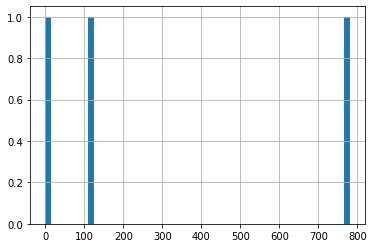

In [126]:
dt['Peak Dwell Time'].hist(bins=50)

In [127]:
dt['Off-Peak Dwell Time'].mean()

300.3333333333333

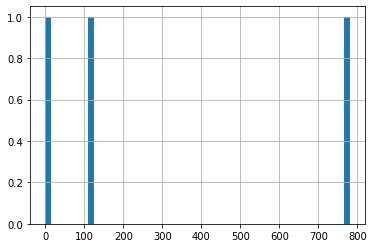

In [128]:
dt['Off-Peak Dwell Time'].hist(bins=50)

# Define Process

In [139]:
class Train(object):  
    def __init__(self, i, line, direction, route, block_cap, maxPassengers=400):
        self.name = line+'-'+direction+' [Train '+f"{i:2d}"+']'
        self.line=line
        self.direction=direction
        self.route = route
        self.p     = 0
        self.maxP  = maxPassengers
    
    def process(self):
        here = self.route[0]   # starting location
        print(here)
        yield env.timeout(0)
        #when station is Old Oak, enter the blocks
#         for k in range(len(block_cap)):
#             with blocks[k].request() as req:
#                 yield req
        
        for dest in self.route[1:]:
            data=dt[dt['Line']==self.line][dt['Direction']==self.direction][dt['From']==here]
            drivetime=data.iloc[0].at['Drive Time']
            print("drivetime ;",drivetime)
            dwelltime=data.iloc[0].at['Off-Peak Dwell Time']
            print("dwell time :", dwelltime)
            yield env.timeout(dwelltime)
            print(f"{now():s} {self.name:s} dep {here:s} for {dest:s}")
            here=dest
            yield env.timeout(drivetime)
            print(f"{now():s} {self.name:s} arr {here:s}")

    def getOff(self, num):
        if self.p >= num:
            print(f"{num:d} passengers got off")
            self.p -= num
        else:
            num = self.p
            print(f"train is empty - only {num:d} passengers got off")
            self.p = 0

    def getOn(self, num):
        if (self.maxP is None) or (self.p + num <= self.maxP):
            print(f"{num:d} passengers got on")
            self.p += num
        else:
            num = self.maxp - self.p
            print(f"train is full - only {num:d} passengers got on")
            self.p = self.maxp



In [140]:
def line(name='HS2', direction='L2B',  start=6*3600, stop=7*3600, timing=300):
    yield env.timeout(0)
    data=dt[dt['Line']==name][dt['Direction']==direction]
    print(data)
    stations=data['From'].to_list()
    print(stations)
    print(type(stations))
    stations+=[data['To'].to_list()[-1]]
    print(stations)
    yield env.timeout(start-env.now) # the line starts operating at 6am
    print(env.now)
    for i in range(int((stop-start)/timing)):
        print(env.now)
        t=Train(i, name, direction, stations, block_cap)
        env.process(t.process())
        yield env.timeout(timing)
        
def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now():
    return daytime(env.now)

env = simpy.Environment()
block_cap = [simpy.Resource(env, capacity = 1) for i in range(blocks)] #assigning individual resource to each block

env.process(line())
env.run()

  Line Direction                    From                        To  Distance  \
0  HS2       L2B           London Euston     London Old Oak Common     23387   
1  HS2       L2B   London Old Oak Common    Birmingham Interchange    145000   
2  HS2       L2B  Birmingham Interchange  Birmingham Curzon Street     42096   

      Speed  Drive Time  Peak Dwell Time  Off-Peak Dwell Time  
0  4.677419       300.0              0.0                  0.0  
1  4.677419      1080.0            780.0                780.0  
2  4.677419       419.0            121.0                121.0  
['London Euston', 'London Old Oak Common', 'Birmingham Interchange']
<class 'list'>
['London Euston', 'London Old Oak Common', 'Birmingham Interchange', 'Birmingham Curzon Street']
21600
21600
London Euston
drivetime ; 300.0
dwell time : 0.0
06:00:00 HS2-L2B [Train  0] dep London Euston for London Old Oak Common
21900
London Euston
06:05:00 HS2-L2B [Train  0] arr London Old Oak Common
drivetime ; 1080.0
dwell time : 780

# System Verification

The first step is always verification using selective traces.

06:00:01 HS2-Southbound [Train  0] dep London Euston for London Old Oak Common
06:00:05 HS2-Southbound [Train  0] arr London Old Oak Common
06:00:22 HS2-Southbound [Train  0] dep London Old Oak Common for Birmingham Interchange
06:00:36 HS2-Southbound [Train  0] arr Birmingham Interchange
06:00:40 HS2-Southbound [Train  0] dep Birmingham Interchange for Birmingham Curzon Street
06:00:45 HS2-Southbound [Train  0] arr Birmingham Curzon Street
06:05:01 HS2-Southbound [Train  1] dep London Euston for London Old Oak Common
06:05:05 HS2-Southbound [Train  1] arr London Old Oak Common
06:05:22 HS2-Southbound [Train  1] dep London Old Oak Common for Birmingham Interchange
06:05:36 HS2-Southbound [Train  1] arr Birmingham Interchange
06:05:40 HS2-Southbound [Train  1] dep Birmingham Interchange for Birmingham Curzon Street
06:05:45 HS2-Southbound [Train  1] arr Birmingham Curzon Street
06:10:01 HS2-Southbound [Train  2] dep London Euston for London Old Oak Common
06:10:05 HS2-Southbound [Train 

# Integrate Statistics

# System Validation

# Simulation Study

# References

[SimPy](https://simpy.readthedocs.io/en/latest/contents.html)